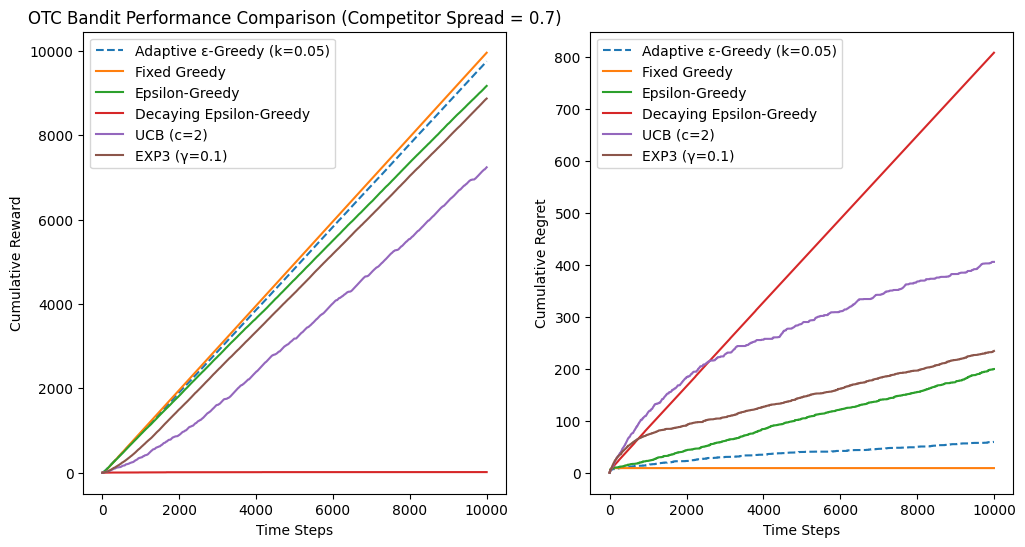

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class OTCEvironment:
    def __init__(self, spreads, competitor_spread, alpha=0.3):
        self.spreads = np.array(spreads)
        self.competitor_spread = competitor_spread
        self.alpha = alpha
        
    def get_execution_prob(self, s):
        if s < self.competitor_spread:
            return 1 / (1 + np.exp(self.alpha * (self.competitor_spread - s)))
        else:
            return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread + 0.1)))
        
    def pull_arm(self, arm):
        s = self.spreads[arm]
        prob = self.get_execution_prob(s)
        win = np.random.binomial(1, prob)
        return win * s

class AdaptiveEpsilonGreedy:
    def __init__(self, num_arms, k):
        self.num_arms = num_arms
        self.k = k
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        if np.random.random() < self._calculate_epsilon():
            return np.random.randint(self.num_arms)  # Exploration
        else:
            return np.argmax(self.values)  # Exploitation
            
    def _calculate_epsilon(self):
        n_min = np.min(self.counts) if np.all(self.counts > 0) else 1
        return min(1, self.k * np.sqrt(np.log(self.t) / n_min))
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# Modified UCB for OTC environment (needs different exploration)
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# Modified EXP3 for OTC environment
class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)
        
    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    rewards = []
    regrets = []
    
    # Precompute optimal arm
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        
        # Calculate regret
        current_expected = env.spreads[arm] * env.get_execution_prob(env.spreads[arm])
        regret = optimal_reward - current_expected
        regrets.append(regret)
        rewards.append(1 if arm == optimal_arm else 0)
    
    return np.cumsum(rewards), np.cumsum(regrets)

# Experiment setup
spreads = [0.1, 0.3, 0.5, 0.7, 0.9]
num_arms = len(spreads)
env = OTCEvironment(spreads, competitor_spread=0.7, alpha=0.4) # Higher alpha means higher competitive market
num_steps = 10000

def epsilon_schedule(t):
    #return 1 / (t + 1)
    #return 1 / np.sqrt(t + 1)
    return np.log(t)/(t+1)

# Run experiments

# Adaptive ε-Greedy
k = 0.05
aeg_reward, aeg_regret = run_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env, num_steps)

# Test multiple k values for AdaptiveEpsilonGreedy
'''
k_values = np.linspace(0.05, 1, 5)  # [0.1, 0.325, 0.55, 0.775, 1.0]
aeg_results = []

for k in k_values:
    reward, regret = run_experiment(AdaptiveEpsilonGreedy, 
                                  {'num_arms': len(spreads), 'k': k}, 
                                  env, num_steps)
    aeg_results.append((k, reward, regret))
'''
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 50}, env, num_steps)
epsilon_greedy_reward, epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
# UCB
ucb_reward, ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, env, num_steps)
# EXP3
exp3_reward, exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, env, num_steps)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(aeg_reward, label=f'Adaptive ε-Greedy (k={k:.2f})', linestyle='--')

# Plot AEG variants
'''
for k, reward, _ in aeg_results:
    plt.plot(reward, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(fixed_exploration_greedy_reward, label='Fixed Greedy')
plt.plot(epsilon_greedy_reward, label='Epsilon-Greedy')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label='UCB (c=2)')
plt.plot(exp3_reward, label='EXP3 (γ=0.1)')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.title("OTC Bandit Performance Comparison (Competitor Spread = 0.7)")

plt.subplot(1, 2, 2)

plt.plot(aeg_regret, label=f'Adaptive ε-Greedy (k={k:.2f})', linestyle='--')

# Plot AEG variants
'''
for k, _, regret in aeg_results:
    plt.plot(regret, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(fixed_exploration_greedy_regret, label='Fixed Greedy')
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label='UCB (c=2)')
plt.plot(exp3_regret, label='EXP3 (γ=0.1)')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()